In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import Grid
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import Grid



In [2]:
archivo = "../osm/edificio/run/001_ExportVariabletoCSV/report_ZoneMeanAirTemperature_ZoneTimestep.csv"
def zones_osm(archivo):
    """ Regresa un dataframe y la lista de nombres de cada columna, quita las unidades
    a las columnas, acepta un archivo proveniente de OpenStudio con temperaturas de 
    las zonas térmics"""
    nombres = np.genfromtxt(archivo,max_rows=1, dtype="U",delimiter=",")
    # zonas = [nombre for nombre in nombres if "Zone Mean Air Temperature" in nombre]
    tmp = pd.read_csv(archivo,skiprows=1,names=nombres,index_col=0,parse_dates=True)
    zonas = [nombre[:-29] for nombre in nombres[1:]]
    tmp.columns = zonas
    return tmp, zonas



In [11]:
def graph_mean_std_max(data,zonas,vmax=40,vmin=10,renglones=5,columnas=5,figsize=(14,10)):
    """ Grafica el día promedio para cada columna del dataframe recibido en verde, la desviación
    estándard en
    """
    tmp = []
    for zona in zonas:
        tmp1 = data[zona].groupby(by=[data.index.time]).agg(["mean","std","max","min"])
        tmp1 = tmp1.add_prefix(zona+"_")
        tmp.append(tmp1)
    tmp2 = pd.concat(tmp,axis=1)
    tmp2.index = pd.to_datetime(tmp2.index,format="%H:%M:%S")
    def plot_mean_max_min(ax,data,zona,vmin=vmin,vmax=vmax):
        mean = zona + "_mean"
        std  = zona + "_std"
        Max = zona + "_max"
        Min  = zona + "_min"
        ax.plot(data[mean])
        ax.fill_between(data[mean].index,data[mean] + data[std],data[mean]-data[std],alpha=0.2)
        ax.plot(data[Max],"r:")
        ax.plot(data[Min],"r:")
        ax.set_ylim(vmin,vmax)
        ax.set_xlabel('Tiempo [hh:mm]')
        ax.set_ylabel('Tem [oC]')
        ax.set_title(zona)
        ax.grid()
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6)) # tick every two hours
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))


    rows = renglones
    columns = columnas
    fig = plt.figure(figsize=figsize)
    grid = Grid(fig, rect=111, nrows_ncols=(rows, columns),axes_pad=0.25)
    for i,ax in enumerate(grid):
        try:
            mean = zonas[i] + "_mean"
            std  = zonas[i] + "_std"
            Max  = zonas[i] + "_max"
            Min  = zonas[i] + "_min"
            plot_mean_max_min(ax,tmp2,zonas[i],vmin=vmin,vmax=vmax)
        except:
            pass
    plt.tight_layout()


In [12]:
data,zonas = zones_osm(archivo)

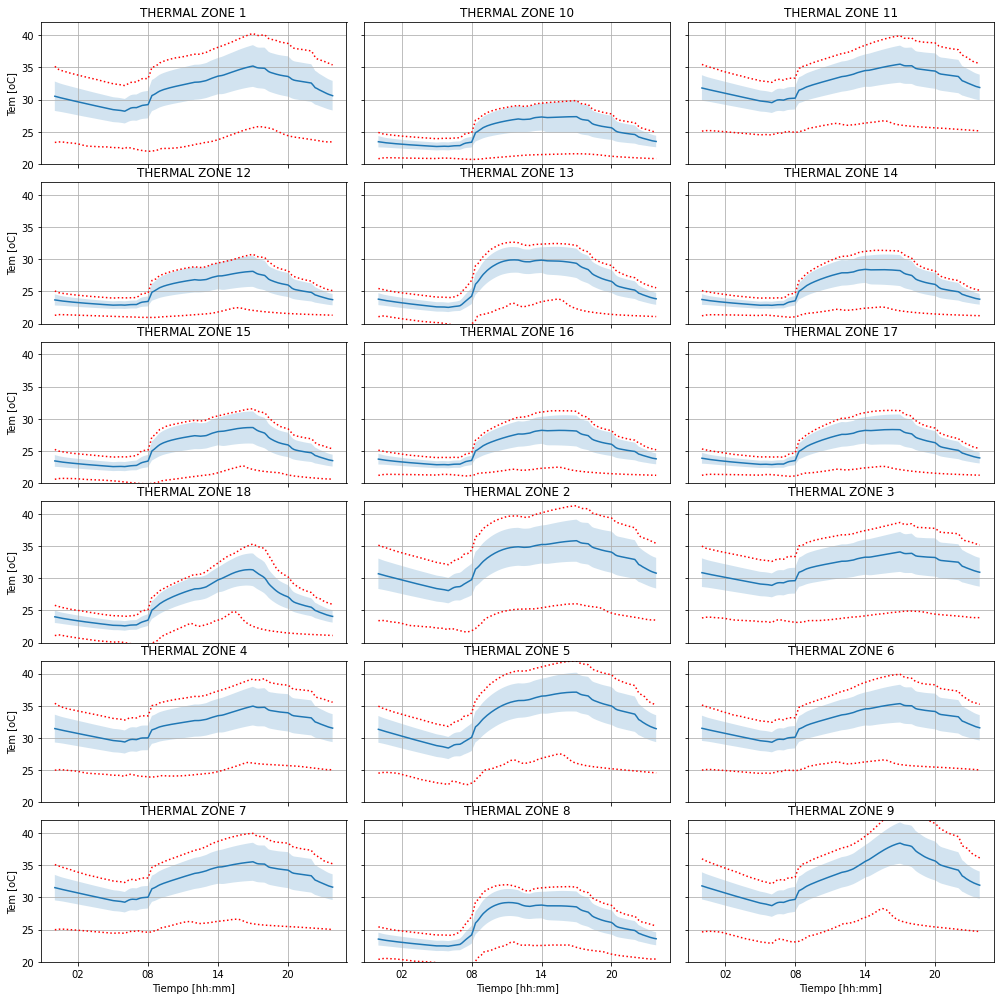

In [20]:
graph_mean_std_max(data,zonas,columnas=3,renglones=6,vmax=42,vmin=20,figsize=(14,14))